In [1]:
%pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import inflect
from datasets import Dataset
from torch.utils.data import DataLoader
import nltk
import json
import re
import numpy as np
from sklearn.model_selection import train_test_split
import requests
from sklearn.utils.class_weight import compute_class_weight
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, Trainer, pipeline, BertTokenizerFast, BertForTokenClassification
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Text Extraction

In [ ]:
data_path = r''
df = pd.read_csv(data_path)
df = df.rename(columns={'max(page)': 'url'})
urls = df['url'].tolist()
df

,url
0,https://www.factorybuys.com.au/products/euro-t...
1,https://dunlin.com.au/products/beadlight-cirrus
2,https://themodern.net.au/products/hamar-plant-...
3,https://furniturefetish.com.au/products/oslo-o...
4,https://hemisphereliving.com.au/products/
...,...
699,https://signaturefinefurniture.ca/products/jac...
700,http://aonefurniture.in/userdata/products/no%2...
701,https://furnituremama.com/products/three-door-...
702,https://gfurniture.ca/products/


In [ ]:
nltk.download('punkt')  # Download necessary data for sentence tokenization
def fetch_page_content(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None

def split_product_list(text):
    # Use a regex to split on capitalized words and spaces
    product_list = re.split(r'(?<!\w)(?=\b[A-Z])', text)
    return [product.strip() for product in product_list if product.strip()]

def extract_text(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    full_text = soup.get_text(separator=' ', strip=True)  # Get all text
    sentences = nltk.sent_tokenize(full_text)  # Split text into sentences
    return sentences


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
url_sentences = []  # List to store the URLs and their corresponding sentences
for url in urls:
    content = fetch_page_content(url)
    if content:
        sentences = extract_text(content)
        url_sentences.append({'url': url, 'sentences': sentences})

df_pages = pd.DataFrame(url_sentences)
df_pages.head()


Error fetching https://furniturefetish.com.au/products/oslo-office-chair-white: 403 Client Error: Forbidden for url: http://ww16.furniturefetish.com.au/products/oslo-office-chair-white?sub1=20241021-0125-0917-82b9-322be484a26d
Error fetching https://hemisphereliving.com.au/products/: 403 Client Error: Forbidden for url: https://hemisphereliving.com.au/products/
Error fetching https://home-buy.com.au/products/bridger-pendant-larger-lamp-metal-brass: HTTPSConnectionPool(host='home-buy.com.au', port=443): Max retries exceeded with url: /products/bridger-pendant-larger-lamp-metal-brass (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7ecb0a501b70>: Failed to resolve 'home-buy.com.au' ([Errno -2] Name or service not known)"))


KeyboardInterrupt: 

In [ ]:
df_pages['sentences'] = df_pages['sentences'].apply(lambda x: '|||'.join(x))


In [ ]:
df_pages

In [ ]:
df_pages.to_csv('webpage_texts.csv', index=False, escapechar='\\')  # Set the escape character


In [ ]:
df_pages.to_json('webpage_texts.json', orient='records', lines=True)  # Records format is often useful for row-wise data


# Products list

In [ ]:
def generate_singular_plural_lists(file_path):
    singular_list = []
    plural_list = []

    with open(file_path, 'r') as file:
        for line in file:
            product_name = line.strip().lower()  # Remove spaces and convert to lowercase
            product_plural = p.plural(product_name).lower()  # Generate plural form and convert to lowercase
            singular_list.append(product_name)  # Add singular form to singular_list
            plural_list.append(product_plural)  # Add plural form to plural_list

    return singular_list, plural_list

In [ ]:
def remove_duplicates(product_list):
    """Remove duplicates from the list of products, keeping only unique values."""
    unique_products = list(set(product_list))  # Convert to set to remove duplicates, then back to list
    return unique_products

In [ ]:
p = inflect.engine()
data_path = r''
singular_list, plural_list = generate_singular_plural_lists(data_path)
singular_list = remove_duplicates(singular_list)
plural_list = remove_duplicates(plural_list)

# Dataset


In [ ]:
data_path = r''
df = pd.read_csv(data_path)
df['sentences'] = df['sentences'].apply(lambda x: x.split('|||') if isinstance(x, str) else [])
df

,url,sentences
0,https://www.factorybuys.com.au/products/euro-t...,[Factory Buys 32cm Euro Top Mattress - King Sk...
1,https://dunlin.com.au/products/beadlight-cirrus,[Beadlight Cirrus LED Reading Light\n– Dunlin ...
2,https://themodern.net.au/products/hamar-plant-...,[Hamar Plant Stand - Ash\n– The Modern Skip to...
3,https://interiorsonline.com.au/products/interi...,[Gift Cards | RJ Living Skip to content The Oc...
4,https://livingedge.com.au/products/tables/dining,"[Dining Tables | Living Edge To continue, plea..."
...,...,...
269,https://thebeachfurniture.com.au/products/gift...,[Gift Card – The Beach Furniture Skip to conte...
270,https://signaturefinefurniture.ca/products/jac...,[Signature Woodworking Furniture Skip to conte...
271,http://aonefurniture.in/userdata/products/no%2...,[Aone Furniture You need to enable JavaScript ...
272,https://furnituremama.com/products/three-door-...,[Wargatogel Daftar Situs Togel Terbesar - Toto...


In [ ]:
all_sentences = []
for index, row in df.iterrows():
    sentences = row['sentences']
    all_sentences.extend(sentences)

In [ ]:
print(len(all_sentences))

6700


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cetusian/ner-model-furniture-names-v2")
model = AutoModelForTokenClassification.from_pretrained("cetusian/ner-model-furniture-names-v2", from_tf=True)

# Load the NER pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


All TF 2.0 model weights were used when initializing DistilBertForTokenClassification.

All the weights of DistilBertForTokenClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForTokenClassification for predictions without further training.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
def merge_adjacent_entities(ner_results, min_confidence=0.5, exclude_words=None):
    """Merge adjacent product entities and return a list."""

    if exclude_words is None:
        exclude_words = ['all', 'sale', 'new', 'shop', 'log', 'search', 'twitter', 'pinterest', 'view', 'about',
                         'styles', 'shipping', 'orders', 'contact', 'trade', 'email', 'linkedin', 'privacy',
                         'help & faq', 'subscribe', 'customer', 'slideshow', 'find', 'facebook',
                         'tiktok', 'youtube', 'returns', 'sustainability', 'stockist', 'gift', 'a', 'the',
                         'website', 'terms', 'help', 'showroom', 'tweet', 'copyright', 'visit', 'buy', 'enter'
                         'sign up', 'site',  'link', 'links', 'online', 'your']  # Add any common words to exclude
    not_products = ['living', 'dining', '$', 'my', 'domestic', 'conditions', 'home', 'bedroom', 'living room', 'dining room', 'kn',
                    'outdoor', 'sign up', 'pin it pin on pin']

    merged_products = []
    current_product = None
    seen_products = set()  # To track duplicates

    for entity in ner_results:
        product_name = entity['word'].strip().lower()  # Convert to lowercase
        confidence = entity['score']
        start = entity['start']
        end = entity['end']

        # Filter out unwanted entities
        if product_name.startswith('##') or confidence < min_confidence or product_name in exclude_words:
            continue

        # If current_product is None, start a new product
        if current_product is None:
            current_product = {'name': product_name, 'start': start, 'end': end, 'confidence': confidence}
            if product_name in singular_list or product_name in plural_list:
                if product_name not in seen_products:
                    merged_products.append(current_product)
                    seen_products.add(product_name)  # Avoid duplicates
                current_product = None
        else:
            # If current product is adjacent to the previous one
            if start == current_product['end'] + 1:
                current_product['name'] += ' ' + product_name  # Concatenate names
                current_product['end'] = end  # Update end position
                current_product['confidence'] = min(current_product['confidence'], confidence)

                # If the current product is in singular or plural list
                if current_product['name'] in singular_list or current_product['name'] in plural_list:
                    if current_product['name'] not in seen_products:
                        merged_products.append(current_product)
                        seen_products.add(current_product['name'])  # Avoid duplicates
                    current_product = None  # Reset current_product
            else:
                if current_product['name'] not in singular_list and current_product['name'] not in plural_list:
                    if current_product['name'] not in seen_products:
                        merged_products.append(current_product)
                        seen_products.add(current_product['name'])  # Avoid duplicates
                    current_product = None  # Reset current_product
                else:
                    # Add the completed product to the list and start a new one
                    current_product = {'name': product_name, 'start': start, 'end': end, 'confidence': confidence}

    # Add the last product if it exists and is not a duplicate
    if current_product and current_product['name'] not in singular_list and current_product['name'] not in plural_list:
        if current_product['name'] not in seen_products:
            merged_products.append(current_product)

    final_products = [
        product for product in merged_products
        if not any(excluded in product['name'] for excluded in exclude_words) and
        product['name'] not in not_products and
        not product['name'].isdigit() and
        len(product['name']) > 1  # Check if the length is greater than 1
    ]

    # Return the merged products list
    return final_products

In [ ]:
def print_ner_results(ner_results):
    """Prints the NER results in a more structured format."""
    print("Extracted Products:")
    for entity in ner_results:
        entity_group = entity['entity_group']
        product_name = entity['word']
        score = entity['score']
        start_pos = entity['start']
        end_pos = entity['end']

        print(f"Product: {product_name}, Confidence: {score:.2f}, Start: {start_pos}, End: {end_pos}")

# Annotate text

In [ ]:
import re

def annotate_text(text, products):
    # Tokenize the text into words (adjust based on your tokenizer)
    tokens = re.findall(r'\w+|\S', text)  # Split on spaces and keep punctuation
    annotations = []
    products = sorted(products, key=lambda p: len(p['name']), reverse=True)
    current_pos = 0
    for token in tokens:
        token_start_pos = text.find(token, current_pos)  # Find the start position of the token
        token_end_pos = token_start_pos + len(token) - 1  # Find the end position of the token

        # Check if the token matches any product
        matched = False
        for product in products:
            if token_start_pos >= product['start'] and token_end_pos <= product['end']:
                if token_start_pos == product['start']:  # First token of the product
                    annotations.append('B-product')
                else:  # Subsequent tokens of the product
                    annotations.append('I-product')
                matched = True
                break

        # If the token does not match any product, mark it as 'O'
        if not matched:
            annotations.append('O')

        current_pos = token_end_pos + 1


    return tokens, annotations



SyntaxError: invalid syntax (<ipython-input-1-2afac550faf8>, line 35)

In [ ]:

annotated_data = []
for sentence in all_sentences:
  res = ner_pipeline(sentence)
  merged_res = merge_adjacent_entities(res)
  if len(merged_res) > 0:
    tokens, annotations = annotate_text(sentence, merged_res)
    annotated_data.append({
        'sentence': sentence,  # Original sentence
        'tokens': tokens,      # List of tokens
        'annotations': annotations  # List of corresponding labels
    })


In [ ]:
df_annotated = pd.DataFrame(annotated_data)
df_annotated

,sentence,tokens,annotations
0,Factory Buys 32cm Euro Top Mattress - King Ski...,"[Factory, Buys, 32cm, Euro, Top, Mattress, -, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,Home Furniture Home Furniture Bedroom Dining L...,"[Home, Furniture, Home, Furniture, Bedroom, Di...","[B-product, I-product, O, O, B-product, I-prod..."
2,LEARN MORE 4.9 Rated 4.9 out of 5 stars Based ...,"[LEARN, MORE, 4, ., 9, Rated, 4, ., 9, out, of...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,Unit price / per Add Sale Ships for Free 4 % O...,"[Unit, price, /, per, Add, Sale, Ships, for, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,Unit price / per Add Sale Australia Owned & St...,"[Unit, price, /, per, Add, Sale, Australia, Ow...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...
1170,Products | Guaranteed A Fine Furniture | High-...,"[Products, |, Guaranteed, A, Fine, Furniture, ...","[O, O, O, O, O, B-product, O, O, O, O, O, O, O..."
1171,Our furniture selection Guaranteed A Furniture...,"[Our, furniture, selection, Guaranteed, A, Fur...","[O, B-product, O, O, O, O, O, O, O, O, O, O, O..."
1172,BEDROOM BEDROOM BEDROOM BEDROOM BEDROOM BEDROO...,"[BEDROOM, BEDROOM, BEDROOM, BEDROOM, BEDROOM, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1173,Regular Hours Monday - Friday | 10:00am - 7:00...,"[Regular, Hours, Monday, -, Friday, |, 10, :, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
df_annotated['tokens'] = df_annotated['tokens'].apply(lambda x: '||'.join(x))
df_annotated['annotations'] = df_annotated['annotations'].apply(lambda x: '||'.join(x))


In [ ]:
df_annotated

,sentence,tokens,annotations
0,Factory Buys 32cm Euro Top Mattress - King Ski...,Factory||Buys||32cm||Euro||Top||Mattress||-||K...,O||O||O||O||O||O||O||O||O||O||O||O||O||O||O||O...
1,Home Furniture Home Furniture Bedroom Dining L...,Home||Furniture||Home||Furniture||Bedroom||Din...,B-product||I-product||O||O||B-product||I-produ...
2,LEARN MORE 4.9 Rated 4.9 out of 5 stars Based ...,LEARN||MORE||4||.||9||Rated||4||.||9||out||of|...,O||O||O||O||O||O||O||O||O||O||O||O||O||O||O||O...
3,Unit price / per Add Sale Ships for Free 4 % O...,Unit||price||/||per||Add||Sale||Ships||for||Fr...,O||O||O||O||O||O||O||O||O||O||O||O||O||O||O||B...
4,Unit price / per Add Sale Australia Owned & St...,Unit||price||/||per||Add||Sale||Australia||Own...,O||O||O||O||O||O||O||O||O||O||O||O||O||O||O||O...
...,...,...,...
1170,Products | Guaranteed A Fine Furniture | High-...,Products|||||Guaranteed||A||Fine||Furniture|||...,O||O||O||O||O||B-product||O||O||O||O||O||O||O|...
1171,Our furniture selection Guaranteed A Furniture...,Our||furniture||selection||Guaranteed||A||Furn...,O||B-product||O||O||O||O||O||O||O||O||O||O||O|...
1172,BEDROOM BEDROOM BEDROOM BEDROOM BEDROOM BEDROO...,BEDROOM||BEDROOM||BEDROOM||BEDROOM||BEDROOM||B...,O||O||O||O||O||O||O||O||O||O||O||O||O||O||O||O...
1173,Regular Hours Monday - Friday | 10:00am - 7:00...,Regular||Hours||Monday||-||Friday|||||10||:||0...,O||O||O||O||O||O||O||O||O||O||O||O||O||O||O||O...


In [ ]:
df_annotated.to_csv('annotated_sentences.csv', index=False, sep=';', quotechar='"', quoting=2)  # quoting=2 ensures all fields are quoted

In [ ]:
print(df_annotated['annotations'].explode().value_counts())


annotations
O            150334
B-product      2563
I-product      1137
Name: count, dtype: int64


# Fine tune RoBertA model

In [3]:
data_path = r''
df = pd.read_csv(data_path)
df['tokens'] = df['tokens'].apply(lambda x: x.split('||'))
df['annotations'] = df['annotations'].apply(lambda x: x.split('||'))
df

,sentence,tokens,annotations
0,Factory Buys 32cm Euro Top Mattress - King Ski...,"[Factory, Buys, 32cm, Euro, Top, Mattress, -, ...","[O, O, O, O, O, B-product, O, O, O, O, O, O, O..."
1,Home Furniture Home Furniture Bedroom Dining L...,"[Home, Furniture, Home, Furniture, Bedroom, Di...","[B-product, I-product, B-product, I-product, B..."
2,LEARN MORE 4.9 Rated 4.9 out of 5 stars Based ...,"[LEARN, MORE, 4, ., 9, Rated, 4, ., 9, out, of...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,Unit price / per Add Sale Ships for Free 4 % O...,"[Unit, price, /, per, Add, Sale, Ships, for, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,Unit price / per Add Sale Australia Owned & St...,"[Unit, price, /, per, Add, Sale, Australia, Ow...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...
1170,Products | Guaranteed A Fine Furniture | High-...,"[Products, , |Guaranteed, A, Fine, Furniture, ...","[O, O, O, O, O, B-product, O, O, O, O, O, O, O..."
1171,Our furniture selection Guaranteed A Furniture...,"[Our, furniture, selection, Guaranteed, A, Fur...","[O, B-product, O, O, O, O, O, O, O, O, O, O, O..."
1172,BEDROOM BEDROOM BEDROOM BEDROOM BEDROOM BEDROO...,"[BEDROOM, BEDROOM, BEDROOM, BEDROOM, BEDROOM, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1173,Regular Hours Monday - Friday | 10:00am - 7:00...,"[Regular, Hours, Monday, -, Friday, , |10, :, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [4]:
row_idx = 1  # You can set this to the row you're editing
# Remove tokens and annotations starting from index 859 to the end
df.at[row_idx, 'tokens'] = df.at[row_idx, 'tokens'][:860]
df.at[row_idx, 'annotations'] = df.at[row_idx, 'annotations'][:860]
new_sentence = ' '.join(df.at[row_idx, 'tokens'])
df.at[row_idx, 'sentence'] = new_sentence



In [5]:
# print(df.head())
print(type(df['tokens'][0]), type(df['annotations'][0]))


<class 'list'> <class 'list'>


In [7]:
print(df['annotations'].explode().value_counts())


annotations
O            4349
B-product    1076
I-product     764
Name: count, dtype: int64


In [6]:
df = df.head(41)

In [ ]:
df

,sentence,tokens,annotations
0,Factory Buys 32cm Euro Top Mattress - King Ski...,"[Factory, Buys, 32cm, Euro, Top, Mattress, -, ...","[O, O, O, O, O, B-product, O, O, O, O, O, O, O..."
1,Home Furniture Home Furniture Bedroom Dining L...,"[Home, Furniture, Home, Furniture, Bedroom, Di...","[B-product, I-product, B-product, I-product, B..."
2,LEARN MORE 4.9 Rated 4.9 out of 5 stars Based ...,"[LEARN, MORE, 4, ., 9, Rated, 4, ., 9, out, of...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,Unit price / per Add Sale Ships for Free 4 % O...,"[Unit, price, /, per, Add, Sale, Ships, for, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,Unit price / per Add Sale Australia Owned & St...,"[Unit, price, /, per, Add, Sale, Australia, Ow...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5,Email address Submit Facebook Instagram TikTok...,"[Email, address, Submit, Facebook, Instagram, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6,Beadlight Cirrus LED Reading Light\n– Dunlin H...,"[Beadlight, Cirrus, LED, Reading, Light, –, Du...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7,EUR € FJD $ FKP £ GBP £ GYD $ HKD $ HUF Ft ISK...,"[EUR, €, FJD, $, FKP, £, GBP, £, GYD, $, HKD, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
8,PGK K PLN zł PYG ₲ RON Lei RSD РСД SAR ر.س SBD...,"[PGK, K, PLN, zł, PYG, ₲, RON, Lei, RSD, РСД, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9,Find out more FITZROY: (03) 9416 0564 CREMORNE...,"[Find, out, more, FITZROY, :, (, 03, ), 9416, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
unique_annotations = set([annotation for sublist in df['annotations'] for annotation in sublist])
print(len(unique_annotations))
unique_annotations

3


{'B-product', 'I-product', 'O'}

In [ ]:
# Iterate through the DataFrame rows
for i, row in df.iterrows():
    tokens = row['tokens']
    annotations = row['annotations']

    # Check if the length of tokens and annotations match
    if len(tokens) != len(annotations):
        print(f"Row {i} - Token count: {len(tokens)}, Annotation count: {len(annotations)}")

In [ ]:
# Split the data into training and test sets (80% training, 20% testing)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

print(train_dataset)
print(test_dataset)


Dataset({
    features: ['sentence', 'tokens', 'annotations', '__index_level_0__'],
    num_rows: 32
})
Dataset({
    features: ['sentence', 'tokens', 'annotations', '__index_level_0__'],
    num_rows: 9
})


In [ ]:
# Define a label map (adjust based on your labels)
label_map = {"O": 0, "B-product": 1, "I-product": 2}  # Add more labels as needed

# Encode the labels as integers
def encode_labels(examples):
    # Since 'annotations' is a list of labels for each example, map each list of labels to their integer representation
    examples['labels'] = [[label_map[label] for label in labels] for labels in examples['annotations']]
    return examples

train_dataset = train_dataset.map(encode_labels, batched=True)
test_dataset = test_dataset.map(encode_labels, batched=True)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [ ]:
# Tokenize and align the labels
def tokenize_and_align_labels(examples):
    # Tokenize the input tokens (which is a list of tokens)
    tokenized_inputs = tokenizer(
        examples['tokens'], truncation=True, padding='max_length', is_split_into_words=True
    )

    # Get the labels (already encoded as integers)
    labels = examples['labels']

    # Align the labels with tokenized inputs
    new_labels = []
    for i, label in enumerate(labels):
        word_ids = tokenized_inputs.word_ids(i)  # Map tokens back to words
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:  # For special tokens
                label_ids.append(-100)  # Ignored during loss calculation
            elif word_idx != previous_word_idx:  # If this is a new word
                label_ids.append(label[word_idx])
            else:  # Continuation of the same word
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

        new_labels.append(label_ids)

    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs

In [ ]:
# Load RoBERTa model and tokenizer
model_name = "roberta-base"  # You can also use 'roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

# Number of unique labels in your task
num_labels = len(label_map)

# Load the RoBERTa model with token classification head
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",                # Output directory for the trained model
    evaluation_strategy="epoch",            # Evaluate every epoch
    learning_rate=5e-5,                    # Learning rate for training
    per_device_train_batch_size=16,        # Batch size for training
    per_device_eval_batch_size=16,         # Batch size for evaluation
    num_train_epochs=5,                    # Number of training epochs
    logging_dir='./logs',                  # Directory for logs
    logging_steps=5,                      # Log every 10 steps
    weight_decay=0.01,                     # Weight decay to avoid overfitting
    save_steps=1000,                       # Save model every 1000 steps
    report_to='none'
)


trainer = Trainer(
    model=model,                           # The pre-trained model
    args=training_args,                     # The training arguments
    train_dataset=train_dataset,            # The training dataset
    eval_dataset=test_dataset,              # The evaluation dataset
    tokenizer=tokenizer,                    # The tokenizer used to preprocess the data
)


trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.680571
2,No log,0.501981
3,0.863100,0.332564
4,0.863100,0.276198
5,0.511900,0.258143


TrainOutput(global_step=10, training_loss=0.6874991893768311, metrics={'train_runtime': 19.4352, 'train_samples_per_second': 8.232, 'train_steps_per_second': 0.515, 'total_flos': 41807859056640.0, 'train_loss': 0.6874991893768311, 'epoch': 5.0})

In [ ]:
# Save the model and tokenizer after training
model.save_pretrained("")
tokenizer.save_pretrained("")

# Fine tune Weighted RoBertA model

In [ ]:
data_path = r''
df = pd.read_csv(data_path)
df['tokens'] = df['tokens'].apply(lambda x: x.split('||'))
df['annotations'] = df['annotations'].apply(lambda x: x.split('||'))
df

,sentence,tokens,annotations
0,Factory Buys 32cm Euro Top Mattress - King Ski...,"[Factory, Buys, 32cm, Euro, Top, Mattress, -, ...","[O, O, O, O, O, B-product, O, O, O, O, O, O, O..."
1,Home Furniture Home Furniture Bedroom Dining L...,"[Home, Furniture, Home, Furniture, Bedroom, Di...","[B-product, I-product, B-product, I-product, B..."
2,LEARN MORE 4.9 Rated 4.9 out of 5 stars Based ...,"[LEARN, MORE, 4, ., 9, Rated, 4, ., 9, out, of...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,Unit price / per Add Sale Ships for Free 4 % O...,"[Unit, price, /, per, Add, Sale, Ships, for, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,Unit price / per Add Sale Australia Owned & St...,"[Unit, price, /, per, Add, Sale, Australia, Ow...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...
1170,Products | Guaranteed A Fine Furniture | High-...,"[Products, , |Guaranteed, A, Fine, Furniture, ...","[O, O, O, O, O, B-product, O, O, O, O, O, O, O..."
1171,Our furniture selection Guaranteed A Furniture...,"[Our, furniture, selection, Guaranteed, A, Fur...","[O, B-product, O, O, O, O, O, O, O, O, O, O, O..."
1172,BEDROOM BEDROOM BEDROOM BEDROOM BEDROOM BEDROO...,"[BEDROOM, BEDROOM, BEDROOM, BEDROOM, BEDROOM, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1173,Regular Hours Monday - Friday | 10:00am - 7:00...,"[Regular, Hours, Monday, -, Friday, , |10, :, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
row_idx = 1  # You can set this to the row you're editing
# Remove tokens and annotations starting from index 859 to the end
df.at[row_idx, 'tokens'] = df.at[row_idx, 'tokens'][:860]
df.at[row_idx, 'annotations'] = df.at[row_idx, 'annotations'][:860]
new_sentence = ' '.join(df.at[row_idx, 'tokens'])
df.at[row_idx, 'sentence'] = new_sentence


In [ ]:
df = df.head(41)

In [ ]:
df

,sentence,tokens,annotations
0,Factory Buys 32cm Euro Top Mattress - King Ski...,"[Factory, Buys, 32cm, Euro, Top, Mattress, -, ...","[O, O, O, O, O, B-product, O, O, O, O, O, O, O..."
1,Home Furniture Home Furniture Bedroom Dining L...,"[Home, Furniture, Home, Furniture, Bedroom, Di...","[B-product, I-product, B-product, I-product, B..."
2,LEARN MORE 4.9 Rated 4.9 out of 5 stars Based ...,"[LEARN, MORE, 4, ., 9, Rated, 4, ., 9, out, of...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,Unit price / per Add Sale Ships for Free 4 % O...,"[Unit, price, /, per, Add, Sale, Ships, for, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,Unit price / per Add Sale Australia Owned & St...,"[Unit, price, /, per, Add, Sale, Australia, Ow...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5,Email address Submit Facebook Instagram TikTok...,"[Email, address, Submit, Facebook, Instagram, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6,Beadlight Cirrus LED Reading Light\n– Dunlin H...,"[Beadlight, Cirrus, LED, Reading, Light, –, Du...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7,EUR € FJD $ FKP £ GBP £ GYD $ HKD $ HUF Ft ISK...,"[EUR, €, FJD, $, FKP, £, GBP, £, GYD, $, HKD, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
8,PGK K PLN zł PYG ₲ RON Lei RSD РСД SAR ر.س SBD...,"[PGK, K, PLN, zł, PYG, ₲, RON, Lei, RSD, РСД, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9,Find out more FITZROY: (03) 9416 0564 CREMORNE...,"[Find, out, more, FITZROY, :, (, 03, ), 9416, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
# Iterate through the DataFrame rows
for i, row in df.iterrows():
    tokens = row['tokens']
    annotations = row['annotations']

    # Check if the length of tokens and annotations match
    if len(tokens) != len(annotations):
        print(f"Row {i} - Token count: {len(tokens)}, Annotation count: {len(annotations)}")

In [ ]:
print(df['annotations'].explode().value_counts())


annotations
O            4349
B-product    1076
I-product     764
Name: count, dtype: int64


In [ ]:
# Split the data into training and test sets (80% training, 20% testing)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

print(train_dataset)
print(test_dataset)

Dataset({
    features: ['sentence', 'tokens', 'annotations', '__index_level_0__'],
    num_rows: 32
})
Dataset({
    features: ['sentence', 'tokens', 'annotations', '__index_level_0__'],
    num_rows: 9
})


In [ ]:
# Define a label map (adjust based on your labels)
label_map = {"O": 0, "B-product": 1, "I-product": 2}  # Add more labels as needed

# Encode the labels as integers
def encode_labels(examples):
    # Since 'annotations' is a list of labels for each example, map each list of labels to their integer representation
    examples['labels'] = [[label_map[label] for label in labels] for labels in examples['annotations']]
    return examples

train_dataset = train_dataset.map(encode_labels, batched=True)
test_dataset = test_dataset.map(encode_labels, batched=True)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [ ]:
# Load RoBERTa tokenizer
model_name = "roberta-base"  # You can use 'roberta-large' if preferred
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

def tokenize_and_align_labels(examples):
    # Tokenize the text and apply padding and truncation
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",  # Pad to the model's max length (512 for RoBERTa)
        is_split_into_words=True,
        max_length=512,  # Set max_length to 512 (or the model's max input size)
    )

    # Align labels to tokenized inputs
    labels = examples["annotations"]

    # Initialize aligned_labels with padding tokens
    aligned_labels = []

    for i, label in enumerate(labels):
        # Ensure the label list is aligned with tokenized inputs
        tokenized_ids = tokenized_inputs["input_ids"][i]  # Get the tokenized input ids

        # Map string labels to integers
        aligned_label = [label_map.get(l, 0) for l in label]  # Map string labels to integers

        # Align labels with tokenized inputs: pad if necessary
        aligned_label = aligned_label + [0] * (len(tokenized_ids) - len(aligned_label))  # Add padding if labels are shorter
        aligned_label = aligned_label[:len(tokenized_ids)]  # Ensure no over-padding if labels are longer

        aligned_labels.append(aligned_label)

    # Add the aligned labels to the tokenized inputs
    tokenized_inputs["labels"] = aligned_labels

    return tokenized_inputs

# Apply the tokenization and alignment function to the datasets
train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)

# Check the tokenized datasets
print(train_dataset)
print(test_dataset)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Dataset({
    features: ['sentence', 'tokens', 'annotations', '__index_level_0__', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 32
})
Dataset({
    features: ['sentence', 'tokens', 'annotations', '__index_level_0__', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 9
})


In [ ]:
# Labels and counts (assuming you have these from your dataset)
labels = np.array(['O', 'B-product', 'I-product'])  # Convert labels to a NumPy array
label_counts = [4349, 1076, 764]  # Number of occurrences of each label

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1, 2]), y=[0]*2357 + [1]*902 + [2]*660)

# Convert class weights to a tensor for PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

print(f"Class weights: {class_weights_tensor}")

Class weights: tensor([0.5542, 1.4483, 1.9793])


In [ ]:
# Load RoBERTa model and tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

# Number of unique labels in your task
num_labels = len(labels)

# Load the RoBERTa model with token classification head, applying class weights to the loss function
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from typing import Dict

class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights_tensor=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights_tensor = class_weights_tensor  # Store the class weights tensor

    def compute_loss(self, model, inputs, return_outputs=False):
        """
        Compute the loss, overriding the default behavior of the Trainer.
        This adds class weights to the loss function.
        """
        # Forward pass
        outputs = model(**inputs)

        # Get logits and labels
        logits = outputs.logits
        labels = inputs.get("labels")

        # Move the class weights to the same device as the logits (typically GPU)
        device = logits.device
        class_weights_tensor = self.class_weights_tensor.to(device)

        # Apply class weights
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)  # Weighted CrossEntropy
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

        # Log the training loss if needed
        if return_outputs:
            return (loss, outputs)
        return loss

    # Optionally, override log method if you want custom logging behavior
    def log(self, logs: Dict[str, float]):
        # Log both training and validation loss
        if "loss" in logs:
            print(f"Training loss: {logs['loss']}")
        if "eval_loss" in logs:
            print(f"Validation loss: {logs['eval_loss']}")
        super().log(logs)  # Call the default log method to maintain standard logging behavior

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # Output directory for model and logs
    evaluation_strategy="epoch",     # Evaluate every epoch
    learning_rate=5e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=4,              # Number of epochs
    logging_dir='./logs',            # Directory for logs
    logging_steps=10,                # Log every 10 steps
    weight_decay=0.01,               # Weight decay to prevent overfitting
    save_steps=1000,                 # Save model every 1000 steps
    report_to='none',                # Disable integration with external logging platforms
)

# Initialize the custom trainer with the class weights
trainer = CustomTrainer(
    model=model,                     # The pre-trained model
    args=training_args,               # Training arguments
    train_dataset=train_dataset,      # Training dataset
    eval_dataset=test_dataset,        # Evaluation dataset
    tokenizer=tokenizer,              # Tokenizer
    class_weights_tensor=class_weights_tensor  # Pass class weights tensor
)

# Start training
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.261284
2,No log,0.211642
3,No log,0.202969
4,No log,0.200604


Validation loss: 0.26128432154655457
Validation loss: 0.21164242923259735
Validation loss: 0.20296934247016907
Validation loss: 0.20060433447360992


TrainOutput(global_step=8, training_loss=0.5182957649230957, metrics={'train_runtime': 10.2885, 'train_samples_per_second': 12.441, 'train_steps_per_second': 0.778, 'total_flos': 33446287245312.0, 'train_loss': 0.5182957649230957, 'epoch': 4.0})

In [ ]:
# Save the model and tokenizer after training
model.save_pretrained("")
tokenizer.save_pretrained("")

# Fine tune DeBERTa model

In [ ]:
data_path = r''
df = pd.read_csv(data_path)
df['tokens'] = df['tokens'].apply(lambda x: x.split('||'))
df['annotations'] = df['annotations'].apply(lambda x: x.split('||'))
df

,sentence,tokens,annotations
0,Factory Buys 32cm Euro Top Mattress - King Ski...,"[Factory, Buys, 32cm, Euro, Top, Mattress, -, ...","[O, O, O, O, O, B-product, O, O, O, O, O, O, O..."
1,Home Furniture Home Furniture Bedroom Dining L...,"[Home, Furniture, Home, Furniture, Bedroom, Di...","[B-product, I-product, B-product, I-product, B..."
2,LEARN MORE 4.9 Rated 4.9 out of 5 stars Based ...,"[LEARN, MORE, 4, ., 9, Rated, 4, ., 9, out, of...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,Unit price / per Add Sale Ships for Free 4 % O...,"[Unit, price, /, per, Add, Sale, Ships, for, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,Unit price / per Add Sale Australia Owned & St...,"[Unit, price, /, per, Add, Sale, Australia, Ow...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...
1170,Products | Guaranteed A Fine Furniture | High-...,"[Products, , |Guaranteed, A, Fine, Furniture, ...","[O, O, O, O, O, B-product, O, O, O, O, O, O, O..."
1171,Our furniture selection Guaranteed A Furniture...,"[Our, furniture, selection, Guaranteed, A, Fur...","[O, B-product, O, O, O, O, O, O, O, O, O, O, O..."
1172,BEDROOM BEDROOM BEDROOM BEDROOM BEDROOM BEDROO...,"[BEDROOM, BEDROOM, BEDROOM, BEDROOM, BEDROOM, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1173,Regular Hours Monday - Friday | 10:00am - 7:00...,"[Regular, Hours, Monday, -, Friday, , |10, :, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
row_idx = 1  # You can set this to the row you're editing
# Remove tokens and annotations starting from index 859 to the end
df.at[row_idx, 'tokens'] = df.at[row_idx, 'tokens'][:860]
df.at[row_idx, 'annotations'] = df.at[row_idx, 'annotations'][:860]
new_sentence = ' '.join(df.at[row_idx, 'tokens'])
df.at[row_idx, 'sentence'] = new_sentence



In [ ]:
df = df.head(41)
df

,sentence,tokens,annotations
0,Factory Buys 32cm Euro Top Mattress - King Ski...,"[Factory, Buys, 32cm, Euro, Top, Mattress, -, ...","[O, O, O, O, O, B-product, O, O, O, O, O, O, O..."
1,Home Furniture Home Furniture Bedroom Dining L...,"[Home, Furniture, Home, Furniture, Bedroom, Di...","[B-product, I-product, B-product, I-product, B..."
2,LEARN MORE 4.9 Rated 4.9 out of 5 stars Based ...,"[LEARN, MORE, 4, ., 9, Rated, 4, ., 9, out, of...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,Unit price / per Add Sale Ships for Free 4 % O...,"[Unit, price, /, per, Add, Sale, Ships, for, F...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,Unit price / per Add Sale Australia Owned & St...,"[Unit, price, /, per, Add, Sale, Australia, Ow...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
5,Email address Submit Facebook Instagram TikTok...,"[Email, address, Submit, Facebook, Instagram, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6,Beadlight Cirrus LED Reading Light\n– Dunlin H...,"[Beadlight, Cirrus, LED, Reading, Light, –, Du...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7,EUR € FJD $ FKP £ GBP £ GYD $ HKD $ HUF Ft ISK...,"[EUR, €, FJD, $, FKP, £, GBP, £, GYD, $, HKD, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
8,PGK K PLN zł PYG ₲ RON Lei RSD РСД SAR ر.س SBD...,"[PGK, K, PLN, zł, PYG, ₲, RON, Lei, RSD, РСД, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9,Find out more FITZROY: (03) 9416 0564 CREMORNE...,"[Find, out, more, FITZROY, :, (, 03, ), 9416, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
# print(df.head())
print(type(df['tokens'][0]), type(df['annotations'][0]))
print(df['annotations'].explode().value_counts())

# Iterate through the DataFrame rows
for i, row in df.iterrows():
    tokens = row['tokens']
    annotations = row['annotations']

    # Check if the length of tokens and annotations match
    if len(tokens) != len(annotations):
        print(f"Row {i} - Token count: {len(tokens)}, Annotation count: {len(annotations)}")


<class 'list'> <class 'list'>
annotations
O            4349
B-product    1076
I-product     764
Name: count, dtype: int64


In [ ]:
# Split the data into training and test sets (80% training, 20% testing)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

print(train_dataset)
print(test_dataset)


Dataset({
    features: ['sentence', 'tokens', 'annotations', '__index_level_0__'],
    num_rows: 32
})
Dataset({
    features: ['sentence', 'tokens', 'annotations', '__index_level_0__'],
    num_rows: 9
})


In [ ]:
# Define a label map (adjust based on your labels)
label_map = {"O": 0, "B-product": 1, "I-product": 2}  # Add more labels as needed

# Encode the labels as integers
def encode_labels(examples):
    # Since 'annotations' is a list of labels for each example, map each list of labels to their integer representation
    examples['labels'] = [[label_map[label] for label in labels] for labels in examples['annotations']]
    return examples

train_dataset = train_dataset.map(encode_labels, batched=True)
test_dataset = test_dataset.map(encode_labels, batched=True)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [ ]:
max_length = 128  # or whatever value fits your data

# Tokenize and align the labels
def tokenize_and_align_labels(examples):
    # Tokenize the input tokens (which is a list of tokens)
    tokenized_inputs = tokenizer(
        examples['tokens'],
        truncation=True,
        padding='max_length',
        max_length=max_length,
        is_split_into_words=True
    )

    # Get the labels (already encoded as integers)
    labels = examples['labels']

    # Align the labels with tokenized inputs
    new_labels = []
    for i, label in enumerate(labels):
        word_ids = tokenized_inputs.word_ids(i)  # Map tokens back to words
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:  # For special tokens
                label_ids.append(-100)  # Ignored during loss calculation
            elif word_idx != previous_word_idx:  # If this is a new word
                label_ids.append(label[word_idx])
            else:  # Continuation of the same word
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx

                # Pad or truncate label_ids to match max_length
        if len(label_ids) < max_length:
            label_ids += [-100] * (max_length - len(label_ids))  # Pad with -100
        else:
            label_ids = label_ids[:max_length]  # Truncate if necessary

        new_labels.append(label_ids)


    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs

In [ ]:
# Load DeBERTa model and tokenizer
model_name = "microsoft/deberta-v3-base"  # You can also use 'microsoft/deberta-v3-large' for more capacity
tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

# Number of unique labels in your task
num_labels = len(label_map)

# Load the DeBERTa model with token classification head
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=num_labels)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(num_labels)

3


In [ ]:
train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/9 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",                # Output directory for the trained model
    evaluation_strategy="epoch",            # Evaluate every epoch
    learning_rate=2e-5,                    # Learning rate for training
    per_device_train_batch_size=16,        # Batch size for training
    per_device_eval_batch_size=16,         # Batch size for evaluation
    num_train_epochs=5,                    # Number of training epochs
    logging_dir='./logs',                  # Directory for logs
    logging_steps=5,                      # Log every 10 steps
    weight_decay=0.01,                     # Weight decay to avoid overfitting
    save_steps=1000,                       # Save model every 1000 steps
    report_to='none'
)


trainer = Trainer(
    model=model,                           # The pre-trained model
    args=training_args,                     # The training arguments
    train_dataset=train_dataset,            # The training dataset
    eval_dataset=test_dataset,              # The evaluation dataset
    tokenizer=tokenizer,                    # The tokenizer used to preprocess the data

)


trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.095456
2,No log,0.073802
3,0.046900,0.073293
4,0.046900,0.075670
5,0.058400,0.077911


TrainOutput(global_step=10, training_loss=0.05264524519443512, metrics={'train_runtime': 10.0217, 'train_samples_per_second': 15.965, 'train_steps_per_second': 0.998, 'total_flos': 10452153507840.0, 'train_loss': 0.05264524519443512, 'epoch': 5.0})

In [ ]:
# Save the model and tokenizer after training
model.save_pretrained("")
tokenizer.save_pretrained("")

# Test inference RoBERTa

In [ ]:
sentence = "This shop sells home furniture Dining Chairs Wing Chairs"
sentence

'This shop sells home furniture Dining Chairs Wing Chairs'

In [ ]:
def merge_tokens(ner_results):
  mapped_results = []
  current_result = {}

  for entity in ner_results:
      original_label = label_map.get(entity['entity'], entity['entity'])  # Default to original if not found
      word = entity['word']
      if original_label == 'B-product':
          if current_result:
              if not word.startswith("Ġ") and not word.startswith("_"):  # Check if the entity is not empty
                  current_result["word"] += word  # Continuation without space
              else:
                  current_result["word"] = current_result["word"][1:]
                  mapped_results.append(current_result)
                  current_result = {
                      'word': word,
                      'label': original_label,
                      'score': entity['score']
                  }
          else:
            current_result = {
                'word': word,
                'label': original_label,
                'score': entity['score']
            }

      elif original_label == 'I-product':
          if current_result:
            if not word.startswith("Ġ") and not word.startswith("_"):  # Check if the entity is not empty
              current_result["word"] += word  # Continuation without space
            else:
              current_result["word"] = current_result["word"][1:]
              mapped_results.append(current_result)
              current_result = {
                  'word': word,
                  'label': original_label,
                  'score': entity['score']
              }
          else:
            current_result = {
                'word': word,
                'label': original_label,
                'score': entity['score']
            }

  if current_result:
      current_result["word"] = current_result["word"][1:]
      mapped_results.append(current_result)

  return mapped_results

In [ ]:
def merge_words(mapped_results):
  merged_products = []
  current_product = ""  # This will hold the current product being formed

  for entity in mapped_results:
      if entity['label'] == 'B-product':
          # If there's an existing product, finalize it before starting a new one
          if current_product:
              merged_products.append(current_product)
          # Start a new product
          current_product = entity['word']
      elif entity['label'] == 'I-product':
          if current_product:
              # Merge the current word into the ongoing product name
              current_product += " " + entity['word']  # Add with space
              # Update the minimum score if the current token's score is lower
          else:
              # If I-product appears without a B-product, you may choose to handle it (optional)
              continue

  # Finalize the last product if it exists
  if current_product:
      merged_products.append(current_product)

  return merged_products

In [ ]:
# Define your label mapping
label_map = {
    "LABEL_0": "O",          # Outside of a named entity
    "LABEL_1": "B-product",  # Beginning of a product entity
    "LABEL_2": "I-product"   # Inside a product entity (if needed)
}

# Load the trained model and tokenizer
model = AutoModelForTokenClassification.from_pretrained("")
tokenizer = AutoTokenizer.from_pretrained("")

device = 0 if torch.cuda.is_available() else -1
# Specify device=0 to use the first GPU
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, device=device)

ner_results = ner_pipeline(sentence)

print(ner_results)
#
mapped_results = merge_tokens(ner_results)


merged_products = merge_words(mapped_results)

print("Extracted Product Names:")
for product in merged_products:
    print(product)

print("--------------------------------------")

[{'entity': 'LABEL_0', 'score': 0.948481, 'index': 1, 'word': 'ĠThis', 'start': 0, 'end': 4}, {'entity': 'LABEL_0', 'score': 0.97838914, 'index': 2, 'word': 'Ġshop', 'start': 5, 'end': 9}, {'entity': 'LABEL_0', 'score': 0.9556398, 'index': 3, 'word': 'Ġsells', 'start': 10, 'end': 15}, {'entity': 'LABEL_1', 'score': 0.49851337, 'index': 4, 'word': 'Ġhome', 'start': 16, 'end': 20}, {'entity': 'LABEL_1', 'score': 0.6508952, 'index': 5, 'word': 'Ġfurniture', 'start': 21, 'end': 30}, {'entity': 'LABEL_1', 'score': 0.949769, 'index': 6, 'word': 'ĠD', 'start': 31, 'end': 32}, {'entity': 'LABEL_1', 'score': 0.9693758, 'index': 7, 'word': 'ining', 'start': 32, 'end': 37}, {'entity': 'LABEL_2', 'score': 0.93987477, 'index': 8, 'word': 'ĠCh', 'start': 38, 'end': 40}, {'entity': 'LABEL_2', 'score': 0.8290009, 'index': 9, 'word': 'airs', 'start': 40, 'end': 44}, {'entity': 'LABEL_1', 'score': 0.9805249, 'index': 10, 'word': 'ĠWing', 'start': 45, 'end': 49}, {'entity': 'LABEL_2', 'score': 0.8535273,

{'sentence': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'annotations': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), '__index_level_0__': Value(dtype='int64', id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Flattened Predictions shape: (1159,)
Flattened Labels shape: (1159,)
Unique labels in actual: [0 1 2]
Unique labels in predictions: [0 1 2]
Classification Report:
              precision    recall  f1-score   support

           O       0.99      0.98      0.98       984
   B-product       0.70      0.88      0.78       101
   I-product       0.96      0.69      0.80        74

    accuracy                           0.95      1159
   macro avg       0.88      0.85      0.86      1159
weighted avg       0.96      0.95      0.95      1159



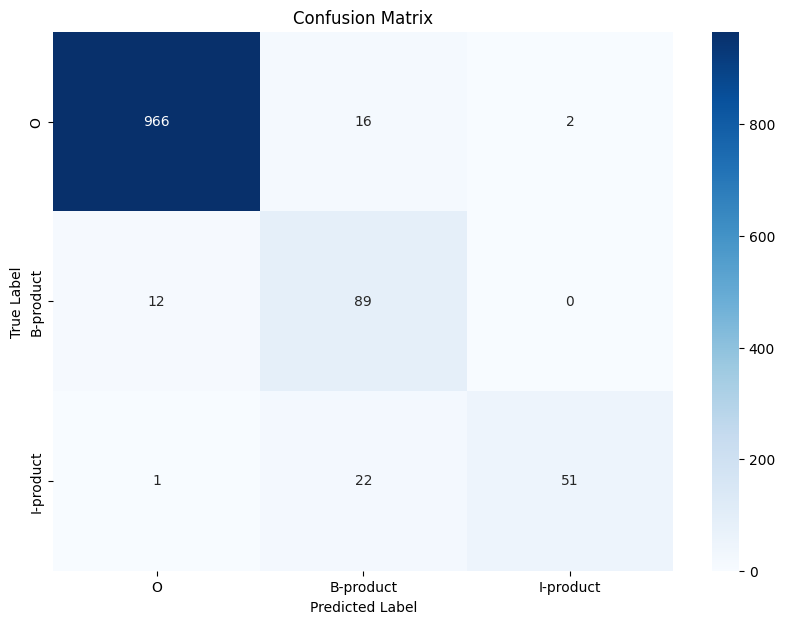

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("")
tokenizer = AutoTokenizer.from_pretrained("")
print(test_dataset.features)

training_args = TrainingArguments(
    output_dir="./results",                # Output directory for the trained model
    evaluation_strategy="epoch",           # Evaluate every epoch
    learning_rate=2e-5,                    # Learning rate for training
    per_device_train_batch_size=16,        # Batch size for training
    per_device_eval_batch_size=16,         # Batch size for evaluation
    num_train_epochs=5,                    # Number of training epochs
    logging_dir='./logs',                  # Directory for logs
    logging_steps=5,                       # Log every 5 steps
    weight_decay=0.01,                     # Weight decay to avoid overfitting
    save_steps=1000,                       # Save model every 1000 steps
    report_to='none'
)

# Instantiate the trainer with loaded model and tokenizer
trainer = Trainer(
    model=model,                           # The pre-trained model
    args=training_args,                     # The training arguments
    train_dataset=train_dataset,            # The training dataset
    eval_dataset=test_dataset,              # The evaluation dataset
    tokenizer=tokenizer,                    # The tokenizer used to preprocess the data
)



# Get predictions from the model
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class indices
predictions = np.argmax(predictions, axis=2)

# Flatten predictions and labels for comparison
predictions = predictions.flatten()
labels = labels.flatten()

# Remove invalid labels (e.g., -100) if present
valid_indices = labels != -100
predictions = predictions[valid_indices]
labels = labels[valid_indices]

# Print shapes for debugging
print("Flattened Predictions shape:", predictions.shape)
print("Flattened Labels shape:", labels.shape)
print("Unique labels in actual:", np.unique(labels))
print("Unique labels in predictions:", np.unique(predictions))

# Compute classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(labels, predictions, target_names=["O", "B-product", "I-product"])
cm = confusion_matrix(labels, predictions)

# Print classification report
print("Classification Report:")
print(report)

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["O", "B-product", "I-product"], yticklabels=["O", "B-product", "I-product"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_dataset

Dataset({
    features: ['sentence', 'tokens', 'annotations', '__index_level_0__', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9
})

Flattened Predictions shape: (787,)
Flattened Labels shape: (787,)
Unique labels in actual: [0 1 2]
Unique labels in predictions: [0]
Classification Report:
              precision    recall  f1-score   support

           O       0.89      1.00      0.94       704
   B-product       0.00      0.00      0.00        48
   I-product       0.00      0.00      0.00        35

    accuracy                           0.89       787
   macro avg       0.30      0.33      0.31       787
weighted avg       0.80      0.89      0.84       787

Confusion Matrix:
[[704   0   0]
 [ 48   0   0]
 [ 35   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


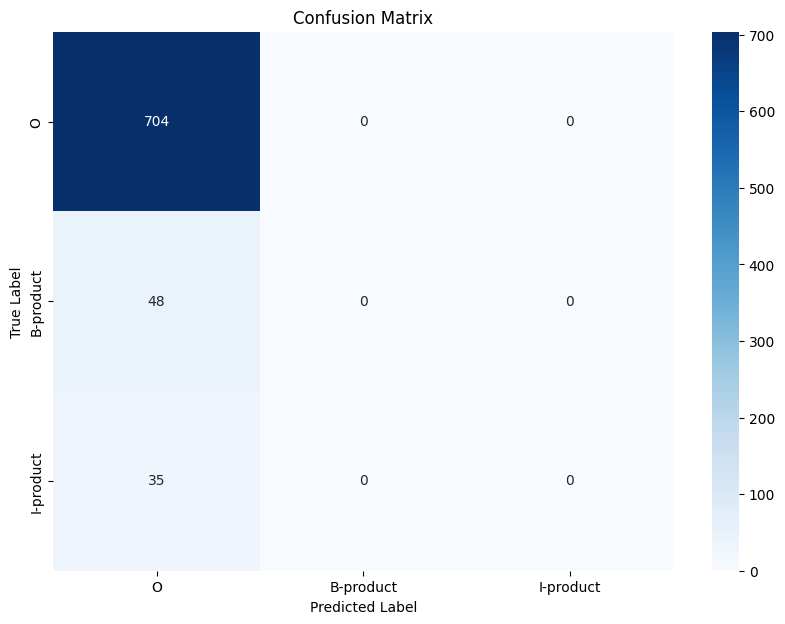

In [ ]:
# Load the trained model and tokenizer
model = AutoModelForTokenClassification.from_pretrained("")
tokenizer = AutoTokenizer.from_pretrained("")

device = 0 if torch.cuda.is_available() else -1
# Specify device=0 to use the first GPU
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, device=device)


# Get the predicted entities from the pipeline
test_sentences = [" ".join(tokens) for tokens in test_dataset['tokens']]  # Convert tokens back into sentences

# Apply NER pipeline to the test data
pipeline_predictions = ner_pipeline(test_sentences)

# Initialize empty lists for predictions and valid labels
predictions = []
valid_labels = []

# Loop over the true labels and predictions to match them correctly
for idx, sentence_pred in enumerate(pipeline_predictions):
    sentence_tokens = test_dataset['tokens'][idx]
    sentence_labels = test_dataset['labels'][idx]

    pred_labels = []
    for token_pred in sentence_pred:
        if token_pred['entity'] == 'B-product':
            pred_labels.append(1)
        elif token_pred['entity'] == 'I-product':
            pred_labels.append(2)
        else:
            pred_labels.append(0)

    # Add to valid labels, ignoring special tokens (-100)
    for label in sentence_labels:
        if label != -100:  # Skip padding/special tokens
            valid_labels.append(label)
            predictions.append(pred_labels.pop(0))  # Add corresponding prediction

# Convert lists to numpy arrays
valid_labels = np.array(valid_labels)
predictions = np.array(predictions)

# Print shapes and unique values for debugging
print("Flattened Predictions shape:", predictions.shape)
print("Flattened Labels shape:", valid_labels.shape)
print("Unique labels in actual:", np.unique(valid_labels))
print("Unique labels in predictions:", np.unique(predictions))

# Define target names based on the unique classes you found
target_names = ["O", "B-product", "I-product"]

# Compute metrics
report = classification_report(valid_labels, predictions, target_names=target_names, labels=[0, 1, 2])
cm = confusion_matrix(valid_labels, predictions)

# Print the classification report
print("Classification Report:")
print(report)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
device = 0 if torch.cuda.is_available() else -1  # 0 for GPU, -1 for CPU

# Define your label mapping
label_map = {
    "LABEL_0": "O",          # Outside of a named entity
    "LABEL_1": "B-product",  # Beginning of a product entity
    "LABEL_2": "I-product"   # Inside a product entity (if needed)
}

# Load the trained model and tokenizer
model = AutoModelForTokenClassification.from_pretrained("")
tokenizer = AutoTokenizer.from_pretrained("")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, device=device)

ner_results = ner_pipeline(sentence)

mapped_results = merge_tokens(ner_results)

merged_products = merge_words(mapped_results)

print("Extracted Product Names:")
for product in merged_products:
    print(product)

Extracted Product Names:


# Test inference DeBERTa model

In [ ]:
sentence = "This shop sells home furniture Dining Chairs Wing Chairs"
sentence

'This shop sells home furniture Dining Chairs Wing Chairs'

In [ ]:
def merge_tokens(ner_results):
  mapped_results = []
  current_result = {}

  for entity in ner_results:
      original_label = label_map.get(entity['entity'], entity['entity'])  # Default to original if not found
      word = entity['word']
      if original_label == 'B-product':
          if current_result:
              if not word.startswith("▁") and not word.startswith("_"):  # Check if the entity is not empty
                  current_result["word"] += word  # Continuation without space
              else:
                  current_result["word"] = current_result["word"][1:]
                  mapped_results.append(current_result)
                  current_result = {
                      'word': word,
                      'label': original_label,
                      'score': entity['score']
                  }
          else:
            current_result = {
                'word': word,
                'label': original_label,
                'score': entity['score']
            }

      elif original_label == 'I-product':
          if current_result:
            if not word.startswith("▁") and not word.startswith("_"):  # Check if the entity is not empty
              current_result["word"] += word  # Continuation without space
            else:
              current_result["word"] = current_result["word"][1:]
              mapped_results.append(current_result)
              current_result = {
                  'word': word,
                  'label': original_label,
                  'score': entity['score']
              }
          else:
            current_result = {
                'word': word,
                'label': original_label,
                'score': entity['score']
            }

  if current_result:
      current_result["word"] = current_result["word"][1:]
      mapped_results.append(current_result)

  return mapped_results

In [ ]:
# Define your label mapping
label_map = {
    "LABEL_0": "O",          # Outside of a named entity
    "LABEL_1": "B-product",  # Beginning of a product entity
    "LABEL_2": "I-product"   # Inside a product entity (if needed)
}

# Load the trained model and tokenizer
model = AutoModelForTokenClassification.from_pretrained("")
tokenizer = AutoTokenizer.from_pretrained("")

device = 0 if torch.cuda.is_available() else -1
# Specify device=0 to use the first GPU
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, device=device)

ner_results = ner_pipeline(sentence)

print(ner_results)

mapped_results = merge_tokens(ner_results)
print("------------------")

print(mapped_results)

merged_products = merge_words(mapped_results)

print("Extracted Product Names:")
for product in merged_products:
    print(product)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'entity': 'LABEL_0', 'score': 0.87013066, 'index': 1, 'word': '▁This', 'start': 0, 'end': 4}, {'entity': 'LABEL_0', 'score': 0.91900843, 'index': 2, 'word': '▁shop', 'start': 4, 'end': 9}, {'entity': 'LABEL_0', 'score': 0.9148442, 'index': 3, 'word': '▁sells', 'start': 9, 'end': 15}, {'entity': 'LABEL_1', 'score': 0.6305754, 'index': 4, 'word': '▁home', 'start': 15, 'end': 20}, {'entity': 'LABEL_2', 'score': 0.7455475, 'index': 5, 'word': '▁furniture', 'start': 20, 'end': 30}, {'entity': 'LABEL_1', 'score': 0.9231364, 'index': 6, 'word': '▁Dining', 'start': 30, 'end': 37}, {'entity': 'LABEL_2', 'score': 0.89293915, 'index': 7, 'word': '▁Chairs', 'start': 37, 'end': 44}, {'entity': 'LABEL_1', 'score': 0.67854583, 'index': 8, 'word': '▁Wing', 'start': 44, 'end': 49}, {'entity': 'LABEL_2', 'score': 0.8222082, 'index': 9, 'word': '▁Chairs', 'start': 49, 'end': 56}]
------------------
[{'word': 'home', 'label': 'B-product', 'score': 0.6305754}, {'word': 'furniture', 'label': 'I-product', 

{'sentence': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'annotations': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), '__index_level_0__': Value(dtype='int64', id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Flattened Predictions shape: (787,)
Flattened Labels shape: (787,)
Unique labels in actual: [0 1 2]
Unique labels in predictions: [0 1 2]
Classification Report:
              precision    recall  f1-score   support

           O       0.98      0.99      0.99       704
   B-product       0.86      0.79      0.83        48
   I-product       0.84      0.77      0.81        35

    accuracy                           0.97       787
   macro avg       0.90      0.85      0.87       787
weighted avg       0.97      0.97      0.97       787



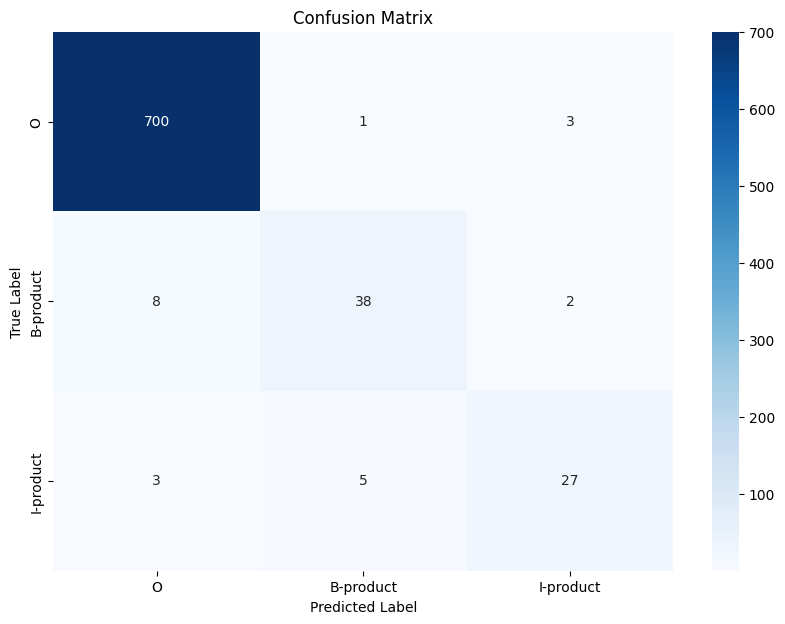

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("")
tokenizer = AutoTokenizer.from_pretrained("")
print(test_dataset.features)

training_args = TrainingArguments(
    output_dir="./results",                # Output directory for the trained model
    evaluation_strategy="epoch",           # Evaluate every epoch
    learning_rate=2e-5,                    # Learning rate for training
    per_device_train_batch_size=16,        # Batch size for training
    per_device_eval_batch_size=16,         # Batch size for evaluation
    num_train_epochs=5,                    # Number of training epochs
    logging_dir='./logs',                  # Directory for logs
    logging_steps=5,                       # Log every 5 steps
    weight_decay=0.01,                     # Weight decay to avoid overfitting
    save_steps=1000,                       # Save model every 1000 steps
    report_to='none'
)

# Instantiate the trainer with loaded model and tokenizer
trainer = Trainer(
    model=model,                           # The pre-trained model
    args=training_args,                     # The training arguments
    train_dataset=train_dataset,            # The training dataset
    eval_dataset=test_dataset,              # The evaluation dataset
    tokenizer=tokenizer,                    # The tokenizer used to preprocess the data
)



# Get predictions from the model
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class indices
predictions = np.argmax(predictions, axis=2)

# Flatten predictions and labels for comparison
predictions = predictions.flatten()
labels = labels.flatten()

# Remove invalid labels (e.g., -100) if present
valid_indices = labels != -100
predictions = predictions[valid_indices]
labels = labels[valid_indices]

# Print shapes for debugging
print("Flattened Predictions shape:", predictions.shape)
print("Flattened Labels shape:", labels.shape)
print("Unique labels in actual:", np.unique(labels))
print("Unique labels in predictions:", np.unique(predictions))

# Compute classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(labels, predictions, target_names=["O", "B-product", "I-product"])
cm = confusion_matrix(labels, predictions)

# Print classification report
print("Classification Report:")
print(report)

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["O", "B-product", "I-product"], yticklabels=["O", "B-product", "I-product"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Inference on actual url

In [ ]:
nltk.download('punkt')  # Download necessary data for sentence tokenization
def fetch_page_content(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.text
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None

def split_product_list(text):
    # Use a regex to split on capitalized words and spaces
    product_list = re.split(r'(?<!\w)(?=\b[A-Z])', text)
    return [product.strip() for product in product_list if product.strip()]

def extract_text(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    full_text = soup.get_text(separator=' ', strip=True)  # Get all text
    sentences = nltk.sent_tokenize(full_text)  # Split text into sentences
    return sentences


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data_path = r''
df = pd.read_csv(data_path)
df['sentences'] = df['sentences'].apply(lambda x: x.split('|||') if isinstance(x, str) else [])
df

,url,sentences
0,https://www.factorybuys.com.au/products/euro-t...,[Factory Buys 32cm Euro Top Mattress - King Sk...
1,https://dunlin.com.au/products/beadlight-cirrus,[Beadlight Cirrus LED Reading Light\n– Dunlin ...
2,https://themodern.net.au/products/hamar-plant-...,[Hamar Plant Stand - Ash\n– The Modern Skip to...
3,https://interiorsonline.com.au/products/interi...,[Gift Cards | RJ Living Skip to content The Oc...
4,https://livingedge.com.au/products/tables/dining,"[Dining Tables | Living Edge To continue, plea..."
...,...,...
269,https://thebeachfurniture.com.au/products/gift...,[Gift Card – The Beach Furniture Skip to conte...
270,https://signaturefinefurniture.ca/products/jac...,[Signature Woodworking Furniture Skip to conte...
271,http://aonefurniture.in/userdata/products/no%2...,[Aone Furniture You need to enable JavaScript ...
272,https://furnituremama.com/products/three-door-...,[Wargatogel Daftar Situs Togel Terbesar - Toto...


In [ ]:
url = df["url"][200]
sentences = []
content = fetch_page_content(url)
if content:
    sentences = extract_text(content)
else:
    print(f"Failed to fetch content from {url}")



label_map = {
    "LABEL_0": "O",          # Outside of a named entity
    "LABEL_1": "B-product",  # Beginning of a product entity
    "LABEL_2": "I-product"   # Inside a product entity (if needed)
}

# Load the trained model and tokenizer
model = AutoModelForTokenClassification.from_pretrained("")
tokenizer = AutoTokenizer.from_pretrained("")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

products = []
results = []

for sentence in sentences:
    ner_results = ner_pipeline(sentence)
    results.append(ner_results)
    mapped_results = merge_tokens(ner_results)
    merged_products = merge_words(mapped_results)
    products.extend(merged_products)

print(results)

products = list(set(products))  # Remove duplicates
products.sort()  # Optional: Sort for better readability
# Display the extracted product names
print("Extracted Product Names:")
for product in products:
    print(product)




Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[[{'entity': 'LABEL_0', 'score': 0.98135287, 'index': 1, 'word': 'ĠSimon', 'start': 0, 'end': 5}, {'entity': 'LABEL_1', 'score': 0.9319468, 'index': 2, 'word': 'ĠSide', 'start': 6, 'end': 10}, {'entity': 'LABEL_1', 'score': 0.50702286, 'index': 3, 'word': 'ĠChair', 'start': 11, 'end': 16}, {'entity': 'LABEL_0', 'score': 0.9981092, 'index': 4, 'word': 'Ġ-', 'start': 17, 'end': 18}, {'entity': 'LABEL_0', 'score': 0.98831916, 'index': 5, 'word': 'Ġsim', 'start': 19, 'end': 22}, {'entity': 'LABEL_0', 'score': 0.99530774, 'index': 6, 'word': 'on', 'start': 22, 'end': 24}, {'entity': 'LABEL_0', 'score': 0.99774265, 'index': 7, 'word': 'Ġ|', 'start': 25, 'end': 26}, {'entity': 'LABEL_0', 'score': 0.98401827, 'index': 8, 'word': 'ĠID', 'start': 27, 'end': 29}, {'entity': 'LABEL_0', 'score': 0.9909497, 'index': 9, 'word': 'S', 'start': 29, 'end': 30}, {'entity': 'LABEL_1', 'score': 0.7761427, 'index': 10, 'word': 'ĠFurn', 'start': 31, 'end': 35}, {'entity': 'LABEL_1', 'score': 0.5751534, 'index

In [ ]:
url = df["url"][202]
sentences = []
content = fetch_page_content(url)
if content:
    sentences = extract_text(content)
else:
    print(f"Failed to fetch content from {url}")



label_map = {
    "LABEL_0": "O",          # Outside of a named entity
    "LABEL_1": "B-product",  # Beginning of a product entity
    "LABEL_2": "I-product"   # Inside a product entity (if needed)
}

# Load the trained model and tokenizer
model = AutoModelForTokenClassification.from_pretrained("")
tokenizer = AutoTokenizer.from_pretrained("")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)

products = []
results = []

for sentence in sentences:
    ner_results = ner_pipeline(sentence)
    results.append(ner_results)
    mapped_results = merge_tokens(ner_results)
    merged_products = merge_words(mapped_results)
    products.extend(merged_products)

print(results)

products = list(set(products))  # Remove duplicates
products.sort()  # Optional: Sort for better readability
# Display the extracted product names
print("Extracted Product Names:")
for product in products:
    print(product)




Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[[{'entity': 'LABEL_0', 'score': 0.9766551, 'index': 1, 'word': '▁Howard', 'start': 0, 'end': 6}, {'entity': 'LABEL_0', 'score': 0.9895866, 'index': 2, 'word': '▁Miller', 'start': 6, 'end': 13}, {'entity': 'LABEL_0', 'score': 0.9243399, 'index': 3, 'word': '▁Niagara', 'start': 13, 'end': 21}, {'entity': 'LABEL_0', 'score': 0.94311243, 'index': 4, 'word': '▁Bar', 'start': 21, 'end': 25}, {'entity': 'LABEL_0', 'score': 0.99469465, 'index': 5, 'word': '▁693', 'start': 25, 'end': 29}, {'entity': 'LABEL_0', 'score': 0.99747485, 'index': 6, 'word': '001', 'start': 29, 'end': 32}, {'entity': 'LABEL_0', 'score': 0.9990828, 'index': 7, 'word': '▁|', 'start': 32, 'end': 34}, {'entity': 'LABEL_0', 'score': 0.9992132, 'index': 8, 'word': '▁Home', 'start': 34, 'end': 39}, {'entity': 'LABEL_0', 'score': 0.978242, 'index': 9, 'word': '▁Bars', 'start': 39, 'end': 44}, {'entity': 'LABEL_0', 'score': 0.99921453, 'index': 10, 'word': '▁USA', 'start': 44, 'end': 48}, {'entity': 'LABEL_0', 'score': 0.99919

# Extract products from all urls

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("")
tokenizer = AutoTokenizer.from_pretrained("")
device = 0 if torch.cuda.is_available() else -1
# Specify device=0 to use the first GPU
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, device=device)


In [ ]:
data_path = r'/content/drive/My Drive/RESEARCH/Veridion/webpage_texts.csv'
df = pd.read_csv(data_path)
df['sentences'] = df['sentences'].apply(lambda x: x.split('|||') if isinstance(x, str) else [])
df


In [ ]:
data = []
stopwords = {"and", "for", "from", "give", "away", "just", "kids", "look", "put"}

label_map = {
    "LABEL_0": "O",          # Outside of a named entity
    "LABEL_1": "B-product",  # Beginning of a product entity
    "LABEL_2": "I-product"   # Inside a product entity (if needed)
}

for index, row in df.iterrows():
    sentences = row['sentences']
    products = []
    for sentence in sentences:
      if len(sentence) > 3000:
        sentence = sentence[:3000]
      ner_results = ner_pipeline(sentence)
      results.append(ner_results)
      mapped_results = merge_tokens(ner_results)
      merged_products = merge_words(mapped_results)
      products.extend(merged_products)


    products = [product.capitalize() for product in products if len(product) > 2 and product.lower() not in stopwords]
    products = list(set(products))  
    products.sort()

    data.append({
      'url': row["url"],
      'products': products
    })
    print(index)


In [ ]:
df = pd.DataFrame(data)
df

In [ ]:
df['products'] = df['products'].apply(lambda x: '|||'.join(x))
df

In [ ]:
df.to_csv('extracted_products.csv', index=False)